In [82]:
import sys
import numpy as np
from simtk import openmm, unit
from simtk.openmm import app

## LJ particles (SDK water model)

$U(r)=\frac{3\sqrt{3}}{2}\epsilon \left( \left(\frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^4 \right) - U({r_c}), r<r_c$

In [91]:
sigma = 0.4371 # nm
epsilon = 0.895*4.184 # kJ/mol
mass = 18*3 # dalton

## Define simulation box
* 3000 water molecules (1000 coarse grained particles)

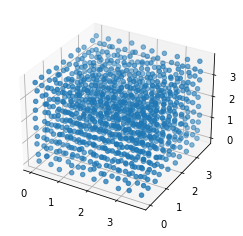

In [84]:
n_particle = 1000
box = np.array([4,4,4])
import itertools
positions = np.array(list(itertools.product(range(10),range(10), range(10))))/10*box
positions += np.random.rand(n_particle,3)*0.1
#print(positions)

from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0],positions[:,1],positions[:,2])

## Define OpenMM topology

In [85]:
top = app.Topology()
chain = top.addChain()
for i in range(1000):
    residue = top.addResidue('WAT', chain)
    top.addAtom('W'+str(i), None, residue)

## Create OpenMM system

In [92]:
system = openmm.System()
system.setDefaultPeriodicBoxVectors(*np.diag(box))
for i in range(1000):
    system.addParticle(mass)
    
    
lj = openmm.CustomNonbondedForce('3*sqrt(3)/2*eps*((sig/r)^12-(sig/r)^4)-Uc;'
                                 'Uc=3*sqrt(3)/2*eps*((sig/rcut)^12-(sig/rcut)^4);'
                                 'rcut=1.5;'
                                 'eps=sqrt(eps1*eps2);'
                                 'sig=(sig1+sig2)/2;')
lj.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
lj.setCutoffDistance(1.5)
lj.addPerParticleParameter('sig')
lj.addPerParticleParameter('eps')
for i in range(1000):
    lj.addParticle([sigma, epsilon])
system.addForce(lj)

barostat = openmm.MonteCarloBarostat(1.0, 300)
system.addForce(barostat)

1

## Integrator (thermostat) and output

In [93]:
platform = openmm.Platform.getPlatformByName('OpenCL')
integrator = openmm.LangevinIntegrator(300, 1.0, 0.01)
sim = app.Simulation(top, system, integrator, platform)

# report properties and trajectory
sim.reporters.append(app.StateDataReporter(sys.stdout, 1000, temperature=True, potentialEnergy=True, step=True, density=True, separator='\t'))
sim.reporters.append(app.PDBReporter('out.pdb', 1000))

## Calculate energy

In [94]:
sim.context.setPositions(positions)

state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

84649.3671875 kJ/mol


## Enenery minimization

In [95]:
openmm.LocalEnergyMinimizer.minimize(sim.context)
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

-30476.37890625 kJ/mol


## Run simulation

In [96]:
sim.step(10000)

#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"
1000	-32643.259765625	303.9556615735434	1.2800659628224704
2000	-34507.046875	282.4274530075559	1.1574240693943967
3000	-33988.3125	300.2880890214842	1.0856799345123627
4000	-32591.197265625	294.0332890410979	0.9994712761159492
5000	-32216.5390625	287.6484904430309	0.9900472364846696
6000	-32355.95703125	289.2006686103374	0.9987747857201276
7000	-32239.27734375	294.115358616004	0.9951450013302345
8000	-32346.30078125	284.7170782252819	0.9944186156559909
9000	-32616.306640625	309.1520941686923	1.007253285275411
10000	-32305.26953125	312.92565917112313	0.9953931353505078


## Visualization

In [97]:
import mdtraj
import nglview
trj = mdtraj.load('out.pdb')
view = nglview.show_mdtraj(trj)
view.add_ball_and_stick('all')
view.center(zoom=True)
view

NGLWidget(max_frame=9)

## Misc

In [ ]:
function = ('3*sqrt(3)/2*eps(type1,type2)*((sig(type1,type2)/r)^12-(sig(type1,type2)/r)^4)+Uc;'
            'Uc=3*sqrt(3)/2*eps(type1,type2)*((sig(type1,type2)/rcut)^12-(sig(type1,type2)/rcut)^4);'
            'rcut=1.5')
epsilon = 0.895 * unit.kilocalorie_per_mole
sigma = 4.371 * unit.angstrom
mass = 18*3 * unit.dalton

In [80]:

lj.addPerParticleParameter('type')
eps = openmm.Discrete2DFunction(1,1,[0.895*4.184])
sig = openmm.Discrete2DFunction(1,1,[0.4371])
lj.addTabulatedFunction('eps', eps)
lj.addTabulatedFunction('sig', sig)

1